# Cutting Cloud Costs with Infrastructure Automation (Part II - EC2 Configuration Automation)
## Review
In the last post, to put it short, I spun up and environment that could've taken up to a half a year to procure, set up, and configure in my past life. We worked with networking, security, computing, and storage components all in one script!

<img src="https://media.giphy.com/media/ZMyLicvZlX7OM/source.gif" style="width: 400px;"/>

At the end of the day, I have an EC2 spun up that's ready to be SSH'ed into and python'ed and jupyter'ed the hell out of. Referring back to our list of to-do items before we can even train our model and look at the results, we still have quite a bit of work cut out for us unfortunately. We have a virtual machine, sure, but now we need to:

6. Install python, CUDA
7. Install common python libraries: pandas, matplotlib, numpy
8. Install domain-specific python libraries: tflearn, tensorflow, sklearn
9. Install additional tools: jupyter
10. Configure tensorflow to work with GPU

Makes sense. We have to actually install all these things and go through all the preliminary set up and configuration to even get TFlearn up and running to train our model. I've never even gone through a post yet where I install python from scratch. Installing python from scratch usually involves donwnloading the _**[Anaconda](https://www.continuum.io/)**_ distribution, which comes pre-loaded with a bunch of libraries and tools useful for data science:

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/chi_lars_face_detection/images/42_anaconda.png" style="width: 800px;"/>

So we can download this first and bypass having to manually install a bunch of libraries. This only gets us so far, though. We still have to install TensorFlow, TFlearn, and figure out all the GPU stuff. I'm not an infrastructure automation engineer, but I've heard of automation tools like _**[Chef](https://www.chef.io/chef/)**_ where you set up a chef server in your infrastructure which has a bunch of "recipes" on what packages each machine should have and the version they should be. The chef server then pushes these "recipes" down to blank servers and automates all downloading, installing, and configuration of these packages (e.g. Anaconda) so we don't have to do it manually. But, man, am I going to have to actually go out and learn _**yet another**_ tool? I feel like I already know too many as it is and I've veered so far off from the actualy objective of this project!

Thanks to Amazon, I really don't have to figure out any of this other stuff! It's not that I don't find this CUDA or automation stuff interesting or important... in fact, I actually _**want**_ to learn it at some point! But just going back to our path of least resistance: if the work has already been done, I would like to leverage that to reach our ultimate objective of training our model. I wouldn't mind revisiting these topics at a later date, or perhaps make a project out of that altogether, but for now, let's introduce Amazon's virtual machine imaging service, _**Amazon Machine Image (AMI)**_.

## Amazon Machine Image (AMI)
When I was setting up my EC2 in Terraform in the last post, I glossed over (and by glossed over, I mean I didn't mention whatsoever) the AMI parameter, but to talk about AMIs, I have to provide some quick context.

Flashback to when we were talking about virtualization a few posts ago: In a virtualized world, we can basically save the state of any operating system into a file called an _**image**_. Linux distributions like [Ubuntu](https://www.ubuntu.com/download/desktop) will provide an image (.iso file) to download which is a blank slate of a machine. Historically, these image files would've been burned on to discs (e.g. remember when Windows used to come on a CD?)

<img src="http://img14.deviantart.net/7a68/i/2007/312/f/b/windows_xp_cd_nov_2007__psd_by_eweiss.jpg" style="width: 300px;"/>

I don't even know if that's real, but that's a goddamn work of art if I ever saw one.

If we fire up a fresh version of Ubuntu and install python on there, we can save _**that state**_ of the operating system into another .iso file and share it with our friends and family (you know, the type of people that would be into this stuff). The point here is that if my bff fires up that .iso image, they would be working in a Ubuntu image with python "pre-installed"!

Fast forward to AMIs - These are Amazon's way of providing virtual machine images. What's nice about Amazon providing this in their cloud infrastructure is that they even have a _**[public marketplace](https://aws.amazon.com/marketplace?)**_ of free and paid AMIs! Poking around, I _**quickly**_ find this [AMI for deep learning](https://aws.amazon.com/marketplace/pp/B01M0AXXQB#product-description). The description of the AMI:

> _The Deep Learning AMI is a base Amazon Linux image provided by Amazon Web Services for use on Amazon Elastic Compute Cloud(Amazon EC2).It is designed to provide a stable, secure, and high performance execution environment for deep learning applications running on Amazon EC2. It includes popular deep learning frameworks, including MXNet, Caffe, Caffe2, **TensorFlow**, Theano, CNTK, Torch and Keras as well as packages that enable easy integration with AWS, including launch configuration tools and many popular AWS libraries and tools. It also includes **Anaconda Data Science Platform for Python2** and Python3. The Deep Learning AMI is provided at no additional charge to Amazon EC2 users._

Well, it's got TensorFlow and a bunch of other NN packages that I've never touched before, Anaconda (which should include matplotlib, sklearn, numpy, pandas, and jupyter), and can easily be spun up on an p2.xlarge box! The only thing I'm not 100% sure about right now is whether or not it has CUDA integration out of the box... Whoop de doo, the first review of the AMI states that:

> _Older reviews of this AMI are out of date. The current version of this AMI comes with **GPU drivers, CUDA, and cuDNN all pre-installed**, as well as many popular deep learning packages. I've used a lot of deep learning packages over the years, and spent way too much time installing them and setting them up -- it's often quite a hassle. Especially with GPU drivers, CUDA, cuDNN, etc. -- downloading, installing, recompiling is a time-suck at best. At worst, I've made mistakes with something not properly installed (but not realizing it) and the software works, but doesn't run as fast as it should. Then I'm not getting the full speed out of the hardware. This AMI takes care of all that guess-work and hassle. Super convenient!_

One thing I'm still left wondering is if the AMI has TFlearn, which I haven't seen mentioned anywhere yet, but I'm not really sure if we really need to look any further than this AMI for now as that step will only take 10 seconds with pip. If I review the return on my investment that I just got in terms of the time it took for me to find this AMI vs the time I would've spent recreating this AMI, I'm quite convinced that the ROI would ballpark around $\infty\%$.

Every EC2 must be spun up with an AMI, the first AMI you see when you try to manually spin one up is the Amazon Linux AMI, which is described as:

> _The Amazon Linux AMI is an EBS-backed, AWS-supported image. The default image includes AWS command line tools, Python, Ruby, Perl, and Java. The repositories include Docker, PHP, MySQL, PostgreSQL, and other packages._

The base Amazon Linux image already comes with quite a bit of stuff!! This Amazon Deep Learning AMI has Anaconda and TensorFlow on top of that, so a well rounded machine right out of the gate! If we look back at our EC2 section of our Terraform script again, we'll see that we do in fact point to the Amazon Deep Learning AMI.

~~~~
resource "aws_spot_instance_request" "aws_deep_learning_custom_spot" {
    ami           = "ami-45fdf753"
    spot_price    = "0.20"
    instance_type = "p2.xlarge"
    security_groups = ["${aws_default_security_group.main_vpc_security_group.id}"]
    subnet_id = "${aws_subnet.main_vpc_subnet.id}"
    key_name = "${var.myKeyPair}"

    tags {
        Name = "aws_deep_learning_custom_spot"
    }
}
~~~~

## Accessing the Amazon Deep Learning AMI
After spinning this guy up, we should theoretically be able to ssh into this guy and access python and jupyter on this machine. Amazon provides this [tutorial](https://aws.amazon.com/blogs/ai/the-aws-deep-learning-ami-now-with-ubuntu/) which shows us how to ssh into their Amazon Deep Learning Ubuntu machine (I can't find their blog post for the Amazon Linux version, I'm not sure if they have one to be honest), but I should be able to use a similar command to get into our Amazon Linux box:

~~~~
ssh -L 8888:localhost:8888 -i <your .pem file name> ec2-user@<Your instance DNS>
~~~~

This command worked for me as per the video below

You'll see at the end of the video, I was able to spin up my EC2 via Terraform, ssh into the Amazon Deep Learning AMI, and access the jupyter notebook.

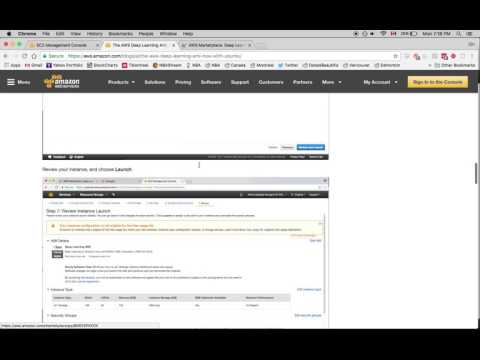

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('Jh0sB_RtvXI')

## Summary
Awesome, almost finished setting up our data / model to train on AWS. In the next post, I'll finish the rest of the to-do list. I'll work with the MNIST data set first and just try to re-train that model.